### XGBoost

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression
from math import sqrt

## Загрузка данных

In [3]:
#Загружаем обучающую и выборку, по которой будем строить предсказания для соревнования
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
#Отделяем целевую переменную и удаляем ее из выборки
Y = data.SalePrice
data.drop('SalePrice', axis=1, inplace=True)

## Первичный анализ

Размер датасета

In [6]:
data.shape

(1460, 80)

In [7]:
#Добавляем к выборкам столбец is_test, по которому будем отличать тренеровочные данных от данных, 
#для которых нужно предсказать цену

tr=data
te=data_test

tr['is_test'] = 0
te['is_test'] = 1

In [8]:
#Соединяем две выборки
df = pd.concat([tr, te])

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [9]:
cat_feat = list(df.dtypes[df.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[cat_feat] = df[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in df if f not in (cat_feat + ['ID', 'is_test'])]

cat_nunique = df[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

MSZoning          6
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64


In [10]:
#Разделяем выборки на ту, по которой будем учиться и ту, на которой будем предсказывать на основе ранее созданного столбца
d_train = df[df.is_test==0].drop('is_test', axis=1)
d_test = df[df.is_test==1].drop('is_test', axis=1)

## Композиции моделей одного семейства

### Будем использовать решающие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> отличный выбор для построения композиций

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
3. Создаем дамми-переменные для категорий

In [11]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)
dummy_train.shape

(1460, 268)

In [12]:
dummy_test.shape

(1459, 256)

In [13]:
dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [14]:
X_train.shape

(1460, 286)

In [15]:
X_test.shape

(1459, 286)

In [20]:
#Короткая функция для вывод RMSD
def met_cl (y_train, y_tr_pred):
    print('RMSD:', sqrt(mean_squared_log_error(y_train, y_tr_pred)))

In [21]:
#Функция для формирования сабмита на Kaggle
def create_submit (clf, X, fileName):
    #Делаем предсказания
    predictions = clf.predict(X)
    #Формируем строку
    submussion = 'Id,SalePrice\n'
    submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(data_test.Id, predictions)])
    #Записываем данные в файл
    with open(fileName, 'w') as file:
        file.write(submussion)

### XGBOOST

In [16]:
import xgboost as xgb

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1}

clf_xgb = xgb.XGBRegressor(**params)
clf_xgb.fit(X_train, Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
y_pred_train = clf_xgb.predict(X_train)

In [26]:
#Считаем RMSD для случайного набора параметров
met_cl(Y, y_pred_train)

RMSD: 0.09200895381987098


In [28]:
#Формируем сабмит
create_submit(clf_xgb, X_test, 'submission_xgb1.txt')

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train, Y, test_size=0.1)

In [39]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1}
clf_xgb = xgb.XGBRegressor(**params)

clf_xgb.fit(X_train_fin, y_train_fin, eval_metric='rmse', eval_set=[[X_train_fin, y_train_fin], [X_val, y_val]])

[0]	validation_0-rmse:179262	validation_1-rmse:175823
[1]	validation_0-rmse:162511	validation_1-rmse:159305
[2]	validation_0-rmse:147497	validation_1-rmse:144543
[3]	validation_0-rmse:133984	validation_1-rmse:131213
[4]	validation_0-rmse:121829	validation_1-rmse:118845
[5]	validation_0-rmse:110883	validation_1-rmse:108132
[6]	validation_0-rmse:101110	validation_1-rmse:98593.1
[7]	validation_0-rmse:92277.6	validation_1-rmse:90123.6
[8]	validation_0-rmse:84400.3	validation_1-rmse:82253.7
[9]	validation_0-rmse:77404.7	validation_1-rmse:75299.5
[10]	validation_0-rmse:71003.8	validation_1-rmse:69047
[11]	validation_0-rmse:65302.5	validation_1-rmse:63504.5
[12]	validation_0-rmse:60239.1	validation_1-rmse:58762.7
[13]	validation_0-rmse:55698.3	validation_1-rmse:54355.6
[14]	validation_0-rmse:51727.4	validation_1-rmse:50654
[15]	validation_0-rmse:48098.4	validation_1-rmse:47160.6
[16]	validation_0-rmse:44876.2	validation_1-rmse:44369.4
[17]	validation_0-rmse:42050.6	validation_1-rmse:41717.5
[

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Возмем параметры, с которых лучше всего начать

In [40]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8}
clf_xgb = xgb.XGBRegressor(**params)

clf_xgb.fit(X_train_fin, y_train_fin, eval_metric='rmse', eval_set=[[X_train_fin, y_train_fin], [X_val, y_val]])

[0]	validation_0-rmse:179210	validation_1-rmse:175682
[1]	validation_0-rmse:162405	validation_1-rmse:159204
[2]	validation_0-rmse:147437	validation_1-rmse:144916
[3]	validation_0-rmse:134123	validation_1-rmse:131876
[4]	validation_0-rmse:121904	validation_1-rmse:120161
[5]	validation_0-rmse:111145	validation_1-rmse:109376
[6]	validation_0-rmse:101447	validation_1-rmse:99595.7
[7]	validation_0-rmse:92623.7	validation_1-rmse:90991.5
[8]	validation_0-rmse:84688.2	validation_1-rmse:82939.6
[9]	validation_0-rmse:77469.5	validation_1-rmse:75821.9
[10]	validation_0-rmse:71178	validation_1-rmse:69781.7
[11]	validation_0-rmse:65587.5	validation_1-rmse:64130.3
[12]	validation_0-rmse:60449.8	validation_1-rmse:59128.2
[13]	validation_0-rmse:55887.7	validation_1-rmse:54655.5
[14]	validation_0-rmse:51839.6	validation_1-rmse:50610.1
[15]	validation_0-rmse:48205.3	validation_1-rmse:47471.5
[16]	validation_0-rmse:45061.5	validation_1-rmse:44284.2
[17]	validation_0-rmse:42200.8	validation_1-rmse:41879.4

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

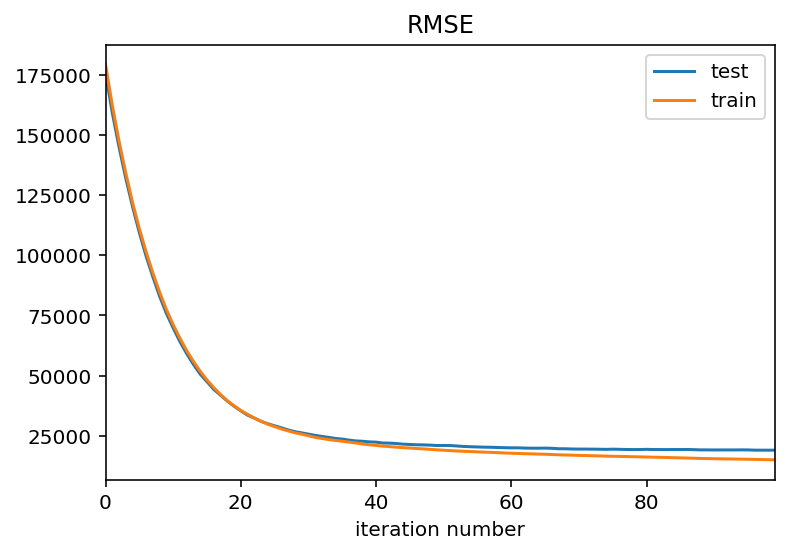

In [41]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['rmse'],
                        'test': clf.evals_result()['validation_1']['rmse']})
res = save_online_metric(clf_xgb)
res.plot(title='RMSE')
plt.xlabel('iteration number')
plt.figure()


Попробуем уменьшить learning_rate.

In [42]:
params = {'n_estimators': 100,
          'learning_rate': 0.03,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8}
clf_xgb = xgb.XGBRegressor(**params)

clf_xgb.fit(X_train_fin, y_train_fin, eval_metric='rmse', eval_set=[[X_train_fin, y_train_fin], [X_val, y_val]])

best_params = params

[0]	validation_0-rmse:192303	validation_1-rmse:188808
[1]	validation_0-rmse:186848	validation_1-rmse:183508
[2]	validation_0-rmse:181639	validation_1-rmse:178273
[3]	validation_0-rmse:176578	validation_1-rmse:173249
[4]	validation_0-rmse:171622	validation_1-rmse:168508
[5]	validation_0-rmse:166835	validation_1-rmse:163909
[6]	validation_0-rmse:162214	validation_1-rmse:159215
[7]	validation_0-rmse:157751	validation_1-rmse:154886
[8]	validation_0-rmse:153383	validation_1-rmse:150440
[9]	validation_0-rmse:149111	validation_1-rmse:146296
[10]	validation_0-rmse:144997	validation_1-rmse:142237
[11]	validation_0-rmse:141032	validation_1-rmse:138312
[12]	validation_0-rmse:137150	validation_1-rmse:134572
[13]	validation_0-rmse:133402	validation_1-rmse:131058
[14]	validation_0-rmse:129793	validation_1-rmse:127484
[15]	validation_0-rmse:126263	validation_1-rmse:124174
[16]	validation_0-rmse:122888	validation_1-rmse:120832
[17]	validation_0-rmse:119590	validation_1-rmse:117614
[18]	validation_0-rm

### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она перебирает параметки по заданной сетке и возврашает лучшие по ROC AUC

In [47]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_log_error', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train_fin, X_val]).values, pd.concat([y_train_fin, y_val]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test RMSE: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

In [48]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBRegressor(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................


IndexError: index 1460 is out of bounds for size 1460

### Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [182]:
from sklearn.tree import DecisionTreeRegressor

clf_tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, Y)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### Считаем RMSD

Делаем предсказания

In [183]:
y_pred_train = clf_tree.predict(X_train)

In [184]:
#Короткая функция для вывод RMSD
def met_cl (y_train, y_tr_pred):
    print('RMSD:', sqrt(mean_squared_log_error(y_train, y_tr_pred)))

In [185]:
#Функция для формирования сабмита на Kaggle
def create_submit (clf, X, fileName):
    #Делаем предсказания
    predictions = clf.predict(X)
    #Формируем строку
    submussion = 'Id,SalePrice\n'
    submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(data_test.Id, predictions)])
    #Записываем данные в файл
    with open(fileName, 'w') as file:
        file.write(submussion)

In [186]:
#Считаем RMSD для дерева
met_cl(Y, y_pred_train)

RMSD: 0.15425210236884798


In [187]:
#Формируем сабмит
create_submit(clf_tree, X_test, 'submission_tree.txt')

### Случайный лес

Бэггинг + случайные подпространства = случайный лес

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [188]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=20, max_features=0.6, n_jobs=-1)

clf_rf.fit(X_train, Y)    

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [189]:
y_pred_rf_train = clf_rf.predict(X_train)

In [190]:
#Считаем RMSD для случайного леса
met_cl(Y, y_pred_rf_train)

RMSD: 0.14335860532096453


In [191]:
#Формируем сабмит на основе случайного леса для Kaggle
create_submit(clf_rf, X_test, 'submission_rf.txt')

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [192]:
#Выводим важности атрибутов
imp = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
imp2 = imp.sort_values(ascending=False).head(25)

In [193]:
imp2

OverallQual          0.481455
GrLivArea            0.122860
GarageCars           0.118447
TotalBsmtSF          0.045054
ExterQual_TA         0.043067
1stFlrSF             0.028903
BsmtFinSF1           0.025422
GarageArea           0.021390
YearBuilt            0.020296
BsmtQual_Ex          0.011867
LotArea              0.010034
TotRmsAbvGrd         0.008830
FullBath             0.008209
2ndFlrSF             0.004591
FireplaceQu_nan      0.003610
Fireplaces           0.003582
YearRemodAdd         0.003155
GarageYrBlt          0.003127
KitchenQual_Gd       0.003049
ExterQual_Gd         0.002683
MasVnrArea           0.002487
BsmtQual_Gd          0.002471
KitchenQual_Ex       0.002308
GarageType_Attchd    0.002241
CentralAir_Y         0.001891
dtype: float64

Явно видно, что одна фича значительно выделяется среди всех остальных - это OverallQual. 
На втором и третьем месте тоже достаточно важные фичи, хотя они и в 4 раза менее значимы первой, но совместо с ней они дают
более 0.72

# Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и к-ближайших соседей

**Преобразуем признаки**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаем дамми-переменные для категорий
4. Нормируем признаки

In [194]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [195]:
X_train_lin.shape

(1460, 366)

### Обучим линейную регрессию

In [196]:
from sklearn.linear_model import LinearRegression

In [197]:
clf_lr = LinearRegression()

clf_lr.fit(X_train_lin, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
y_pred_lin_train = clf_lr.predict(X_train_lin)

In [199]:
met_cl(Y, y_pred_lin_train)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**!!! Не понятно почему не получается посчитать RMSD для линейной регрессии**

### Обучим knn

In [200]:
from sklearn.neighbors import KNeighborsRegressor

In [201]:
clf_knn = KNeighborsRegressor()

In [202]:
clf_knn.fit( X_train_lin, Y )

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [203]:
y_pred_knn_train = clf_knn.predict(X_train_lin)

In [204]:
#Посчитаем RMSD
met_cl(Y, y_pred_knn_train)

RMSD: 0.14171916173658144


In [205]:
#Сделаем сабмит модели построенной по knn для kaggle
create_submit(clf_rf, X_test, 'submission_knn.txt')

### Обучим bagging

In [206]:
from sklearn.ensemble import BaggingRegressor

In [207]:
clf_br = BaggingRegressor()

In [208]:
clf_br.fit( X_train_lin, Y )

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [209]:
y_pred_br_train = clf_br.predict(X_train_lin)

In [210]:
#Посчитаем RMSD
met_cl(Y, y_pred_br_train)

RMSD: 0.06849391856074924


In [211]:
#Сделаем сабмит для kaggle
create_submit(clf_rf, X_test, 'submission_br.txt')

### Построим линейную комбинацию knn и случайного леса

Будем строить линейную комбинацию вида

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

[ 0.]


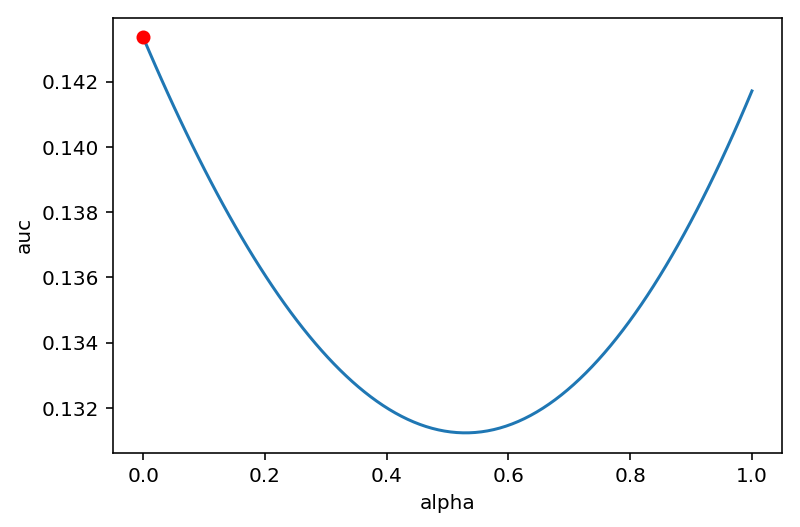

In [212]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_knn_train + (1 - alpha) * y_pred_rf_train
    aucs.append(sqrt(mean_squared_log_error(Y, y_pred_weight)))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]
print(alpha)
plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_knn_train + (1 - alpha) * y_pred_rf_train

In [215]:
for i in alpha:
    print(i)

0.0


### Формируем сабмит из взвешенных предсказаний для kaggle

In [213]:
#Формируем строку
submussion = 'Id,SalePrice\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(data_test.Id, y_pred_weight)])
#Записываем данные в файл
with open('submussion_lk.txt', 'w') as file:
    file.write(submussion)

### Сравним 4 метода (посчитаем RMSD)

In [166]:
print('Weighted:')
met_cl(Y, y_pred_train)
print('KNN:')
met_cl(Y, y_pred_knn_train)
print('Bagging regression:')
met_cl(Y, y_pred_br_train)
print('Random forest:')
met_cl(Y, y_pred_rf_train)


Weighted:
RMSD: 0.15425210236884798
KNN:
RMSD: 0.14171916173658144
Bagging regression:
RMSD: 0.06846575282079398
Random forest:
RMSD: 0.1429955608266036


### Стэкинг

#### Средние значения таргета

Создадим новые признаки, на основе категориальных переменных. Каждому уникальному значению $V$ переменной $X_i$ сопоставим среднее значение таргета среди всех объектов, у которых переменная $X_i$ принимает значение $V$ 

Новый признак со средними значением таргета в категории можно считать за предсказание вер-ти класса 1 простого классификатора "усреднения"

Опишем класс этого классификатора

In [78]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()

    def predict(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return new_feature

Делаем предсказания по фолдам кросс-валидации. **Главное не допустить утечки информации!**

Опишем функцию для стекинга

In [109]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

### Стекинг нескольких моделей
0. Средние значения
1. KNN
2. Bagging regression
3. Random Forest

In [110]:
y_test = y_pred_train

In [113]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=5, random_state=555)

meta_train = []
meta_test = []
col_names = []


print('mean features...')

for c in cat_nunique.index.tolist():
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, Y, d_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('mean_pred_{}'.format(c))


print('BR features...')
meta_tr = get_meta_features(clf_br, X_train_lin, Y, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('br_pred')

print('KNN features...')
meta_tr = get_meta_features(clf_knn, X_train_lin, Y, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knn_pred')

print('RF features...')
meta_tr = get_meta_features(clf_rf, X_train, Y, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('Finish')

mean features...


C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyError: 'MSZoning'

In [101]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью Random Forest

Используем случайный лес в качестве алгоритма второго уровня

In [102]:
clf_rf_meta = RandomForestRegressor()

clf_rf_meta.fit(X_meta_train, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [103]:
y_pred_meta_train = clf_rf_meta.predict(X_meta_train)
y_pred_meta_test = clf_rf_meta.predict(X_meta_test)

In [105]:
met_cl(Y, y_pred_meta_train)

RMSD: 0.06263032802225703


In [106]:
create_submit(clf_lr_meta, X_test, 'submission_ens.txt')

ValueError: Number of features of the model must match the input. Model n_features is 46 and input n_features is 286 

#### Посмотрим на коэффициенты объединяющей линейной модели

Получим интерпретацию общей модели

In [473]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

# Домашняя работа

#### Простая
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

#### Средняя
0. Все то же, что и в части 1, плюс:
1. Попробовать другие оценки важности переменных, например Boruta
http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/#comments
3. Изучить extremely randomized trees (ExtraTreesRegressor в sklearn), сравнить с Random Forest
4. Проводить настройку гиперпараметров для моделей первого уровня в стекинге (перебирать руками и смотреть на CV или по сетке: GridSearchCV, RandomizedSearchCV)
5. Попробовать другие алгоритмы второго уровня
6. Сделать сабмиты на kaggle (минимум 3: отдельные модели vs стекинг), сравнить качество на локальной валидации и на leaderboard
7. В качестве решения:
    * Jupyter notebook с кодом, комментариями и графиками
    * сабмит на kaggle (ник на leaderboard)